In [62]:
import pandas as pd
import numpy as np

# 🏦 Bank Customer Dataset Schema

This notebook documents the schema of a customer dataset used for banking churn analysis. It includes feature descriptions, data types, and inferred meanings to guide preprocessing and modeling.

---

## 📋 Dataset Columns

| Column Name           | Data Type | Description (Inferred)                                      |
|-----------------------|-----------|--------------------------------------------------------------|
| `id`, `CustomerId`    | int64     | Unique identifiers for each customer.                        |
| `Surname`             | object    | Customer's last name.                                        |
| `CreditScore`         | int64     | Credit score of the customer.                                |
| `Geography`, `Gender` | object    | Categorical features representing location and gender.       |
| `Age`                 | float64   | Customer's age.                                              |
| `Tenure`              | int64     | Number of years the customer has been with the bank.         |
| `Balance`             | float64   | Account balance.                                             |
| `EstimatedSalary`     | float64   | Estimated annual salary.                                     |
| `NumOfProducts`       | int64     | Number of bank products the customer uses.                   |
| `HasCrCard`           | float64   | Binary flag: 1 if customer has a credit card, else 0.        |
| `IsActiveMember`      | float64   | Binary flag: 1 if customer is active, else 0.                |
| `Exited`              | int64     | Target variable: 1 if customer exited (churned), else 0.     |

---

## 🧭 Notes

- Binary flags (`HasCrCard`, `IsActiveMember`) are stored as `float64`, which may require conversion to `int` or `bool` for modeling.
- Categorical features (`Geography`, `Gender`) may need encoding (e.g., one-hot or label encoding).
- `Exited` is the target variable for churn prediction.

---

In [63]:
df = pd.read_csv("train.csv")

In [64]:
df.drop(columns=['id' , 'CustomerId' , 'Surname'],inplace=True)

In [65]:
from sklearn.preprocessing import StandardScaler , OneHotEncoder , OrdinalEncoder

In [66]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer

In [67]:
cols = df.columns

In [68]:
X = df.drop(columns='Exited')
y = df['Exited']

In [69]:
preprocessing = ColumnTransformer(
    transformers=[
        ('Gender_Ordinal_Encoder' , OrdinalEncoder() , ['Gender']),
        ('Geography_OHE' , OneHotEncoder(handle_unknown='ignore' , sparse_output=False) , ['Geography'])
    ],remainder=StandardScaler()
)

In [70]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [71]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(
    eta = 0.1 , 
    gamma = 0 , 
    max_depth = 6 , 
    min_child_weight = 2 , 
    n_estimators = 100)

In [72]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ('preprocessing' , preprocessing),
        ('XGB' , xgb_classifier)
    ]
)

In [73]:
pipeline

,steps,"[('preprocessing', ...), ('XGB', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Gender_Ordinal_Encoder', ...), ('Geography_OHE', ...)]"
,remainder,StandardScaler()
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocessing', ...), ('XGB', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Gender_Ordinal_Encoder', ...), ('Geography_OHE', ...)]"
,remainder,StandardScaler()
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [75]:
y_pred = pipeline.predict(X_test)

In [76]:
from sklearn.metrics import accuracy_score,recall_score,precision_score
accuracy_score(y_test,y_pred)

0.8676038416093556

In [77]:
precision_score(y_test,y_pred)

0.7451166318983501

In [ ]:
recall_score(y_test , y_pred)

0.8809489575844716

In [ ]:
num = precision_score(y_test,y_pred) * recall_score(y_test , y_pred)

In [ ]:
deno = precision_score(y_test,y_pred) + recall_score(y_test , y_pred)

In [ ]:
f1_score = 2*(num/deno)

In [ ]:
f1_score

0.8073594624906592

In [ ]:
import pickle
pickle.dump(pipeline,open('pipeline.pkl','wb'))

In [79]:
import shap

In [80]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_classifier)

# Transform data using preprocessing pipeline
X_test_transformed = preprocessing.transform(X_test)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)


In [81]:
feature_names = preprocessing.get_feature_names_out()

In [82]:
feature_names

array(['Gender_Ordinal_Encoder__Gender',
       'Geography_OHE__Geography_France',
       'Geography_OHE__Geography_Germany',
       'Geography_OHE__Geography_Spain', 'remainder__CreditScore',
       'remainder__Age', 'remainder__Tenure', 'remainder__Balance',
       'remainder__NumOfProducts', 'remainder__HasCrCard',
       'remainder__IsActiveMember', 'remainder__EstimatedSalary'],
      dtype=object)

# SHAP Feature Importance Analysis

**SHAP was used to interpret the XGBoost model and understand feature-level contributions to customer churn predictions**

Key observations:
- Features such as Number of Products , Age , isActiveMember , Gender and Balance
  had the highest impact on churn probability.
- Higher age and lower engagement indicators increased churn risk.
- SHAP explanations improve trust and interpretability, making the model
  suitable for real-world business decision-making.


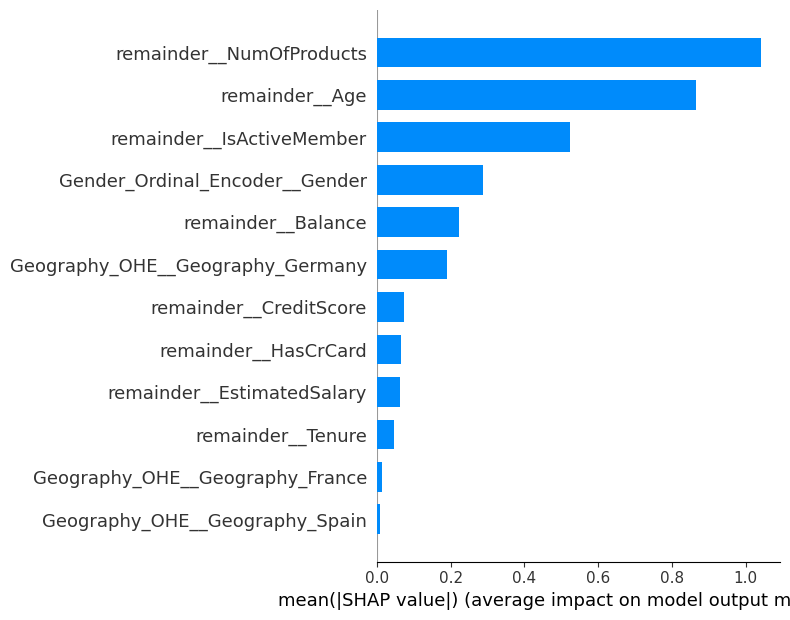

In [83]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar"
)

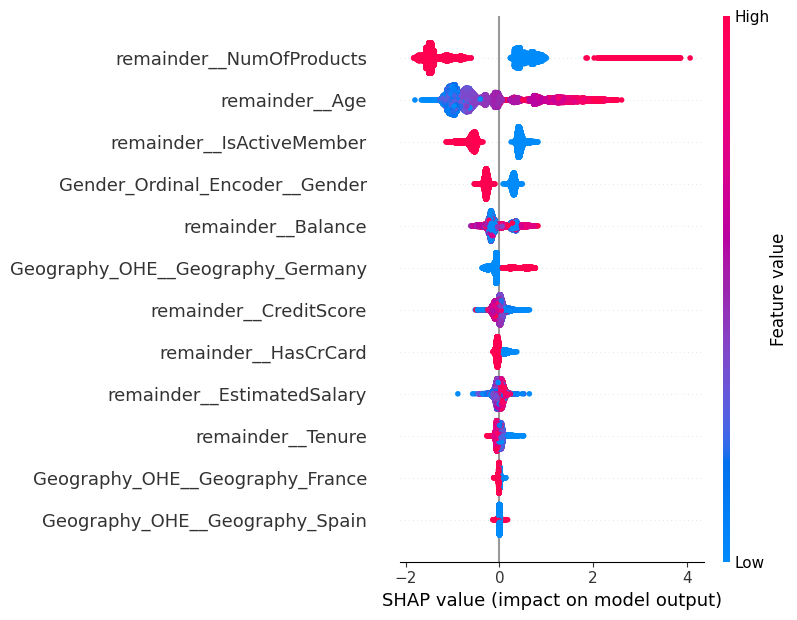

In [84]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)